In [13]:
library(readr)
library(dplyr)
library(ggplot2)
library(gridExtra)
library(lattice)
library(DataExplorer)
library(factoextra)

In [14]:
library(caret)
library(e1071)
library(rpart)
library(rpart.plot)
library(randomForest)
library(Metrics)
library(ROCit)
library(kableExtra)

In [37]:
library(cluster)

Warning message:
"package 'cluster' was built under R version 3.6.3"

In [15]:
setwd("D:/BABI/BABI-5th Residency/Data Mining/Group Assignment")
getwd()

[1] "D:/BABI/BABI-5th Residency/Data Mining/Group Assignment"

In [16]:
library(readxl) #package to read the excel file
bank <- read_excel("Thera Bank-Data Set.xlsx", sheet = "Bank_Personal_Loan_Modelling")
dim(bank)

Warning message:
"package 'readxl' was built under R version 3.6.2"

[1] 5000   14

In [17]:
any(is.na(bank)) #checking for missing values

[1] TRUE

In [18]:
sapply(bank, function(x){sum(is.na(x))}) #checking columns which have missing values

ID        Age (in years) Experience (in years) 
                    0                     0                     0 
  Income (in K/month)              ZIP Code        Family members 
                    0                     0                    18 
                CCAvg             Education              Mortgage 
                    0                     0                     0 
        Personal Loan    Securities Account            CD Account 
                    0                     0                     0 
               Online            CreditCard 
                    0                     0

In [19]:
bank[is.na(bank)]=0  #check again after replacing with 0
any(is.na(bank)) #re-checking for missing values

[1] FALSE

In [20]:
summary(bank)

       ID       Age (in years)  Experience (in years) Income (in K/month)
 Min.   :   1   Min.   :23.00   Min.   :-3.0          Min.   :  8.00     
 1st Qu.:1251   1st Qu.:35.00   1st Qu.:10.0          1st Qu.: 39.00     
 Median :2500   Median :45.00   Median :20.0          Median : 64.00     
 Mean   :2500   Mean   :45.34   Mean   :20.1          Mean   : 73.77     
 3rd Qu.:3750   3rd Qu.:55.00   3rd Qu.:30.0          3rd Qu.: 98.00     
 Max.   :5000   Max.   :67.00   Max.   :43.0          Max.   :224.00     
    ZIP Code     Family members      CCAvg          Education    
 Min.   : 9307   Min.   :0.000   Min.   : 0.000   Min.   :1.000  
 1st Qu.:91911   1st Qu.:1.000   1st Qu.: 0.700   1st Qu.:1.000  
 Median :93437   Median :2.000   Median : 1.500   Median :2.000  
 Mean   :93153   Mean   :2.389   Mean   : 1.938   Mean   :1.881  
 3rd Qu.:94608   3rd Qu.:3.000   3rd Qu.: 2.500   3rd Qu.:3.000  
 Max.   :96651   Max.   :4.000   Max.   :10.000   Max.   :3.000  
    Mortgage     Per

In [21]:
bank = bank[,-c(1,5)] #dropping the first and 5th columns of the dataset

In [22]:
col = c("Education","Personal Loan", "Securities Account", "CD Account", "Online", "CreditCard")
bank[col] = lapply(bank[col], factor)

In [23]:
bank$Education = factor(bank$Education, levels = c("1","2","3"), order = TRUE)

In [24]:
#Abbreviating variable names

bank = bank%>% rename(Age = "Age (in years)", Experience = "Experience (in years)", 
                      Income = "Income (in K/month)")

In [25]:
bank$Experience = abs(bank$Experience) #modulo function for the negative values

dim(bank)

[1] 5000   12

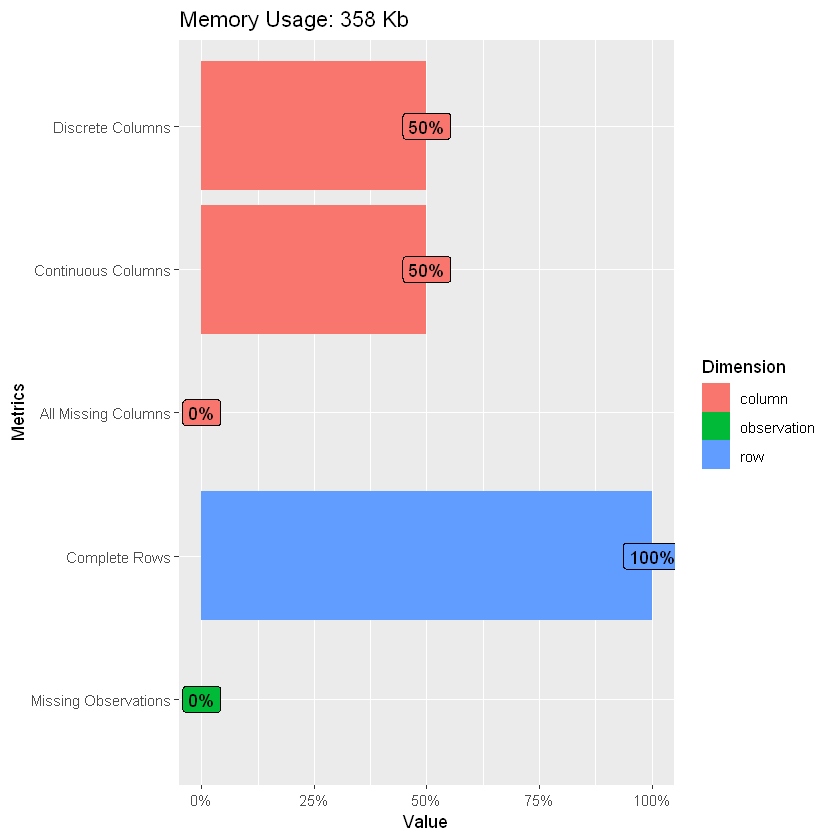

In [26]:
plot_intro(bank)#EDA

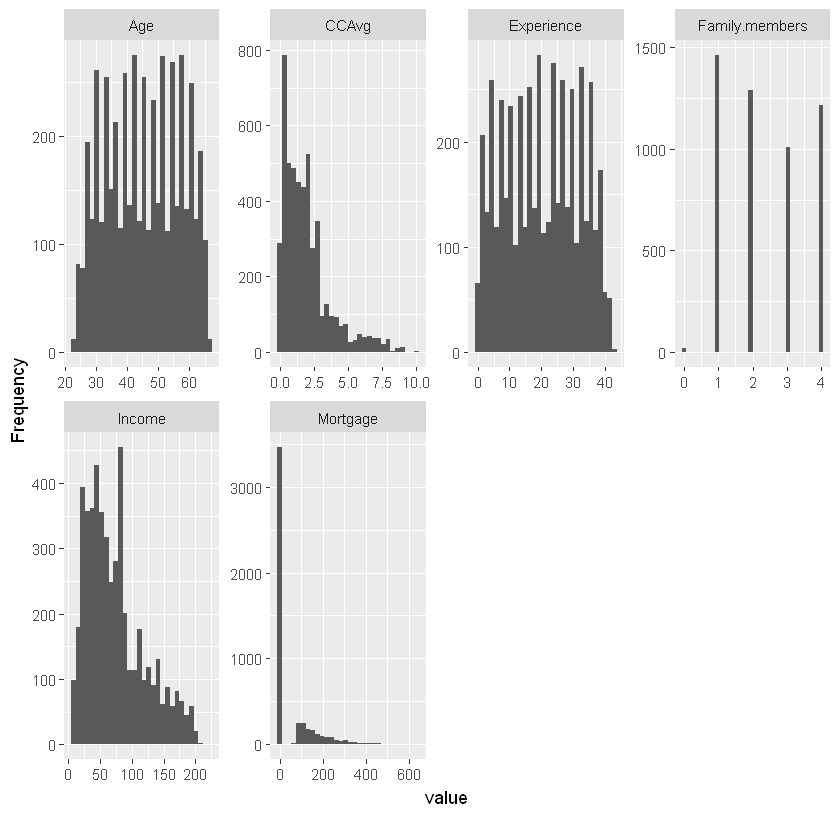

In [27]:
plot_histogram(bank)

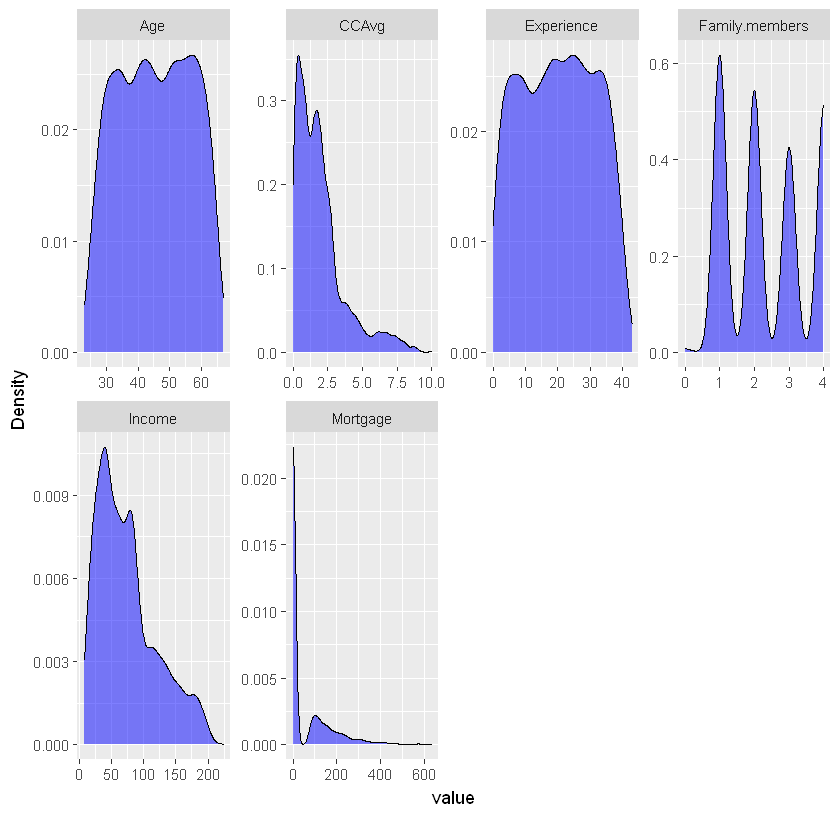

In [28]:
plot_density(bank,geom_density_args = list(fill="blue", alpha=0.5))

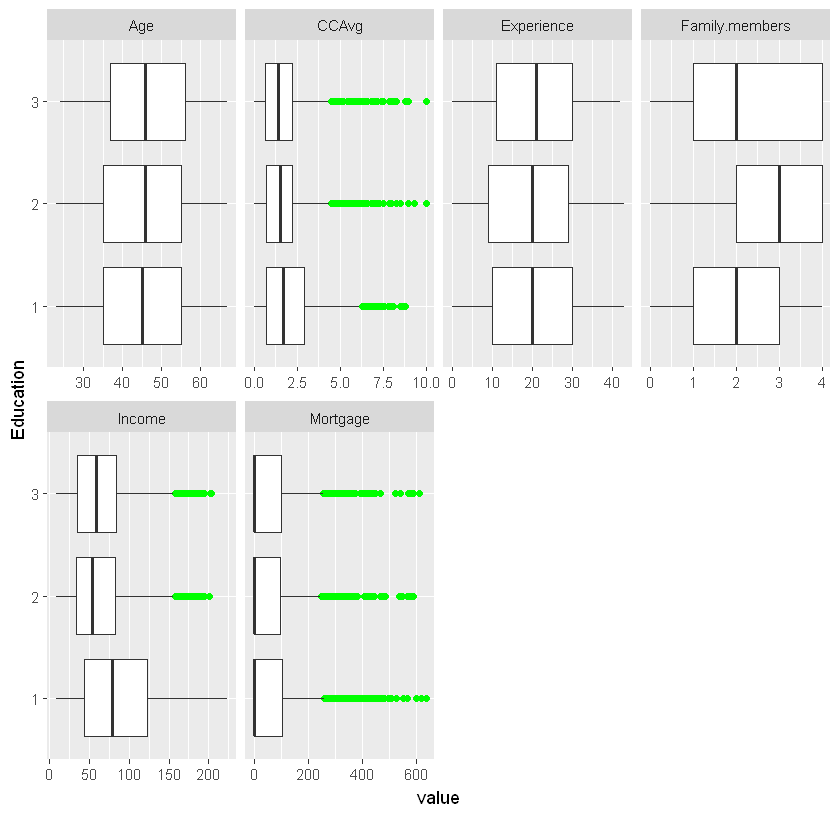

In [29]:
plot_boxplot(bank, by = "Education", geom_boxplot_args = list("outlier.color" = "green"))

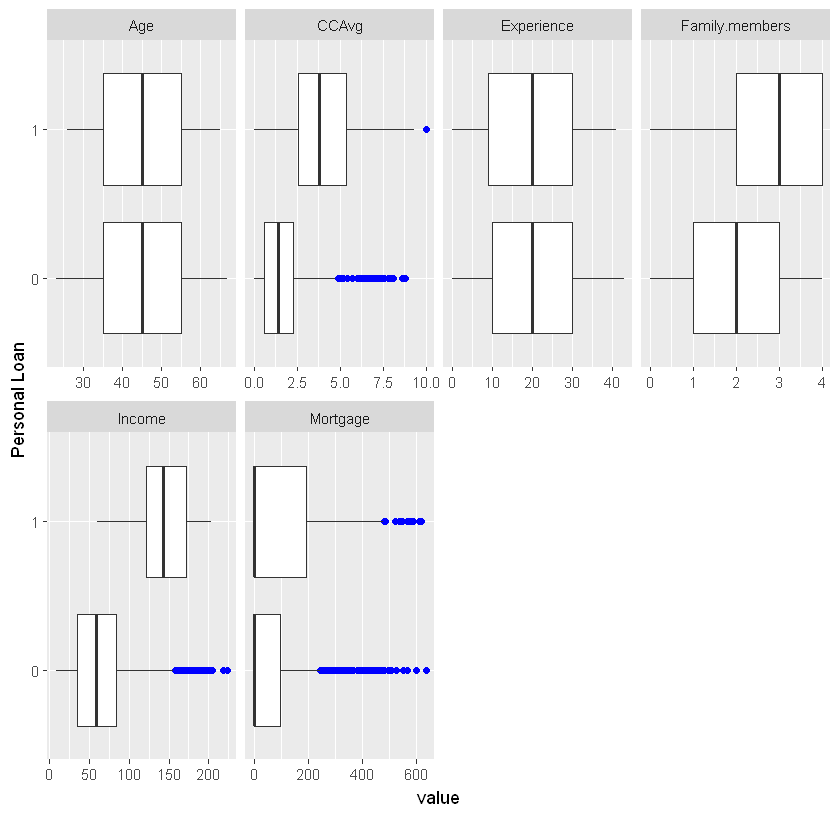

In [30]:
plot_boxplot(bank, by = "Personal Loan", geom_boxplot_args = list("outlier.color" = "blue"))

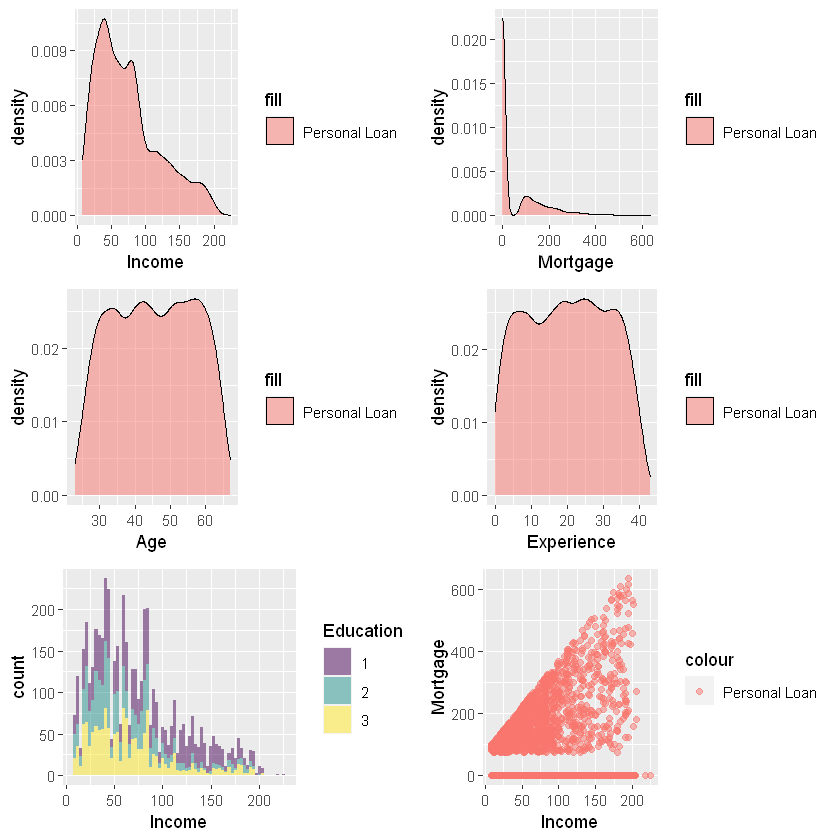

In [31]:
p1 = ggplot(bank, aes(Income, fill= "Personal Loan")) + geom_density(alpha=0.5)
p2 = ggplot(bank, aes(Mortgage, fill= "Personal Loan")) + geom_density(alpha=0.5)
p3 = ggplot(bank, aes(Age, fill= "Personal Loan")) + geom_density(alpha=0.5)

p4 = ggplot(bank, aes(Experience, fill= "Personal Loan")) + geom_density(alpha=0.5)
p5 = ggplot(bank, aes(Income, fill= Education)) + geom_histogram(alpha=0.5, bins = 70)
p6 = ggplot(bank, aes(Income, Mortgage, color = "Personal Loan")) + 
  geom_point(alpha = 0.5)
grid.arrange(p1, p2, p3, p4, p5, p6, ncol = 2, nrow = 3)

Warning message:
"Use of `bank$`Personal Loan`` is discouraged. Use `Personal Loan` instead."Warning message:
"Use of `bank$`Personal Loan`` is discouraged. Use `Personal Loan` instead."

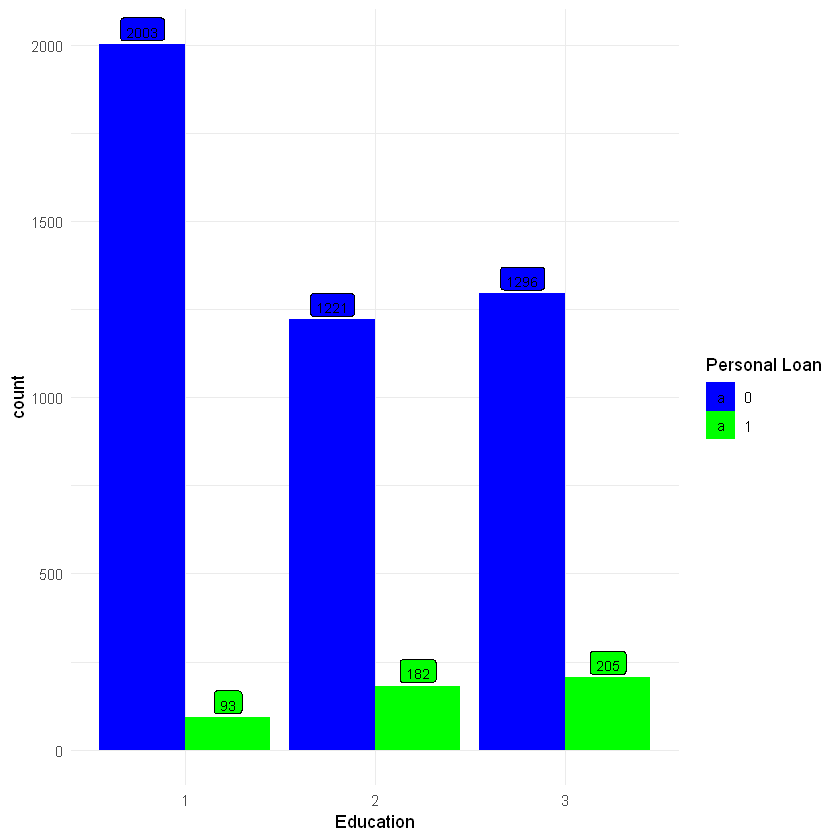

In [32]:
#number of personal loans taken w.r.t. education


ggplot(bank, aes(Education,fill= bank$`Personal Loan`)) + 
  geom_bar(stat = "count", position = "dodge") +
  geom_label(stat = "count", aes(label= ..count..), 
             size = 3, position = position_dodge(width = 0.9), vjust=-0.15)+
  scale_fill_manual("Personal Loan", values = c("0" = "blue", "1" = "green"))+
  theme_minimal()

Warning message:
"Use of `bank$`Personal Loan`` is discouraged. Use `Personal Loan` instead."

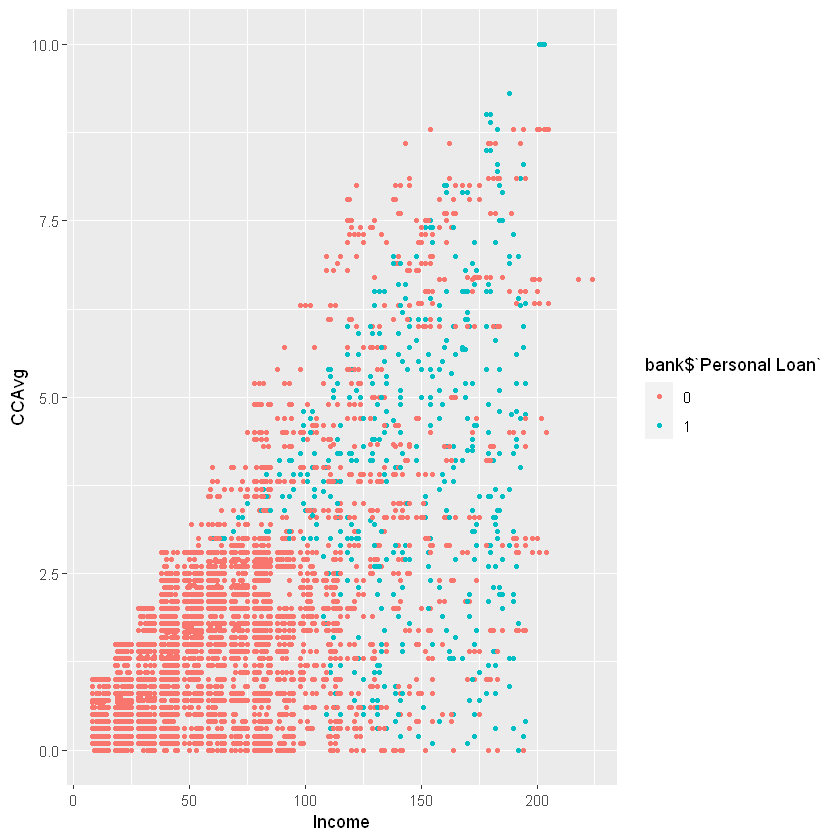

In [33]:
#number of personal loans taken w.r.t. credit card

ggplot(bank, aes(Income,y = CCAvg, color = bank$`Personal Loan`)) + 
  geom_point(size = 1)

Warning message:
"Use of `bank$`Personal Loan`` is discouraged. Use `Personal Loan` instead."

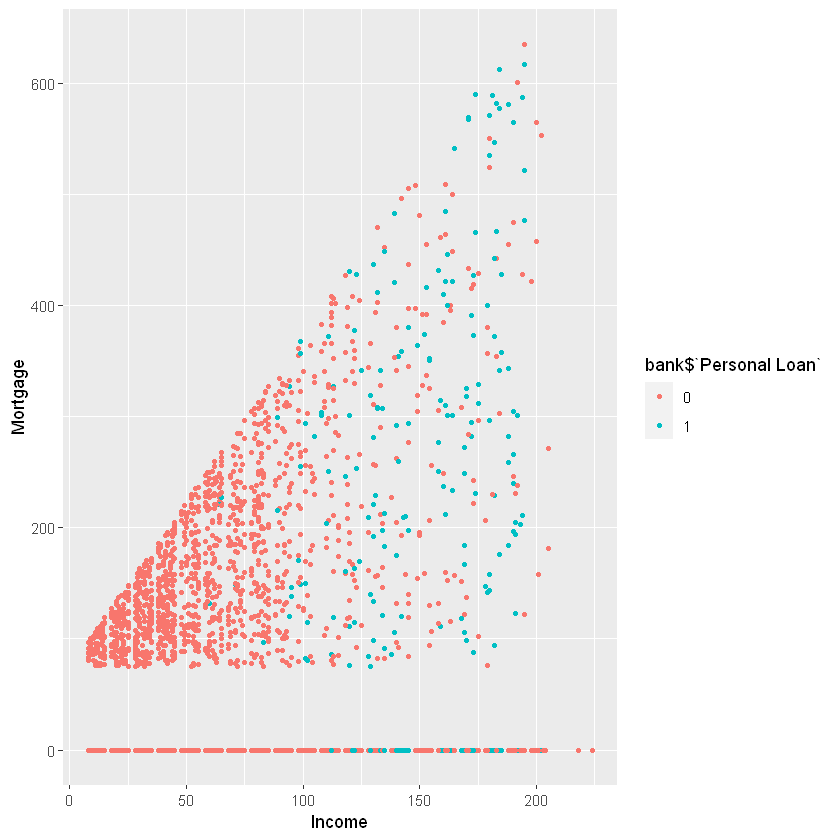

In [34]:
#number of personal loans taken w.r.t. mortgage

ggplot(bank, aes(Income,y = Mortgage, color = bank$`Personal Loan`)) + 
  geom_point(size = 1)

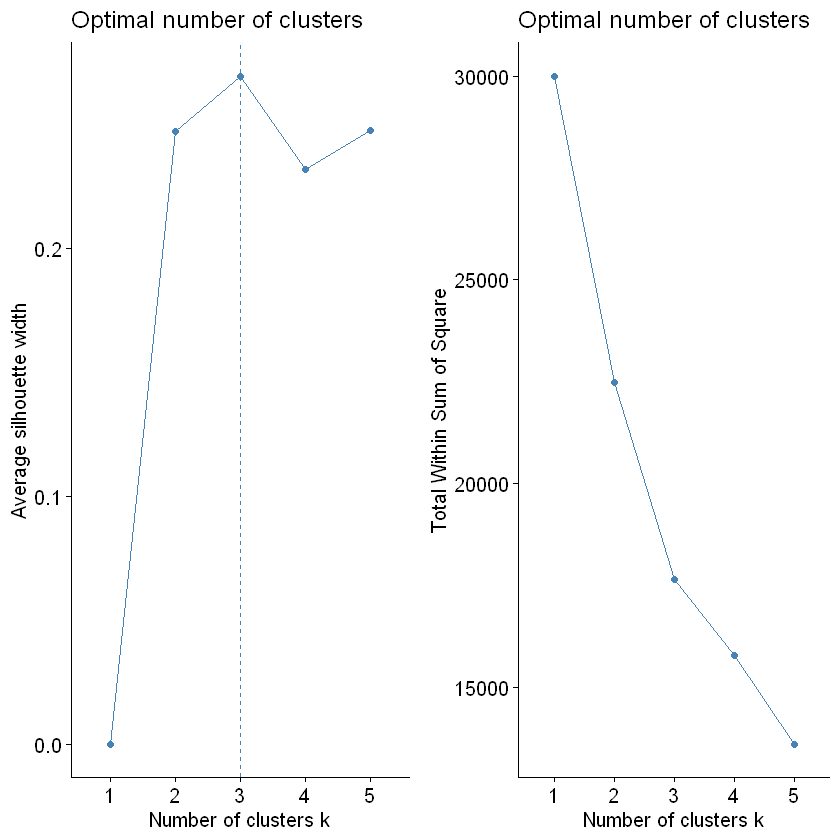

In [38]:
#Clustering begins

bank.clust = bank %>% select_if(is.numeric)

bank.scale = scale(bank.clust, center = TRUE)  #scaling the cluster

bank.dist = dist(bank.scale, method = "euclidean") #calculating the euclidean distance

## checking optimal number of clusters to categorize dataset 

p12 = fviz_nbclust(bank.scale, kmeans, method = "silhouette", k.max = 5) # k-means clustering is used
p21 = fviz_nbclust(bank.scale, kmeans, method = "wss", k.max = 5)

grid.arrange(p12, p21, ncol=2)

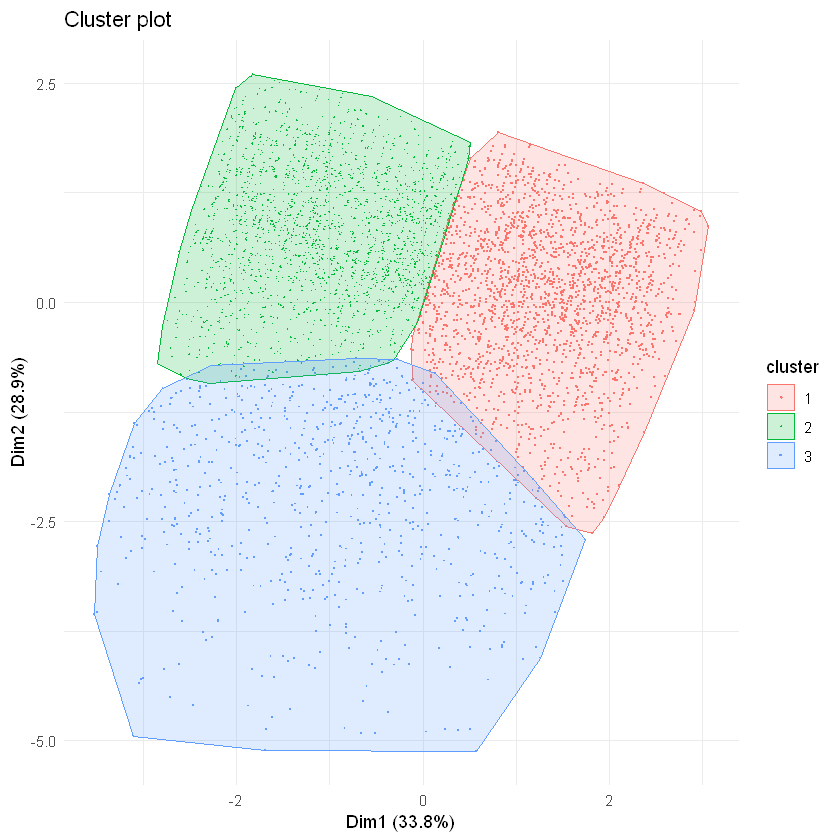

In [39]:
#k-means clustering

set.seed(8787)
bank.clusters = kmeans(bank.scale, 3, nstart = 10)

fviz_cluster(bank.clusters, bank.scale, geom = "point", 
             ellipse = TRUE, pointsize = 0.2, ) + theme_minimal()

In [40]:
#splitting dataset into train and test

set.seed(1233)

## sampling 70% of data for training the algorithms using random sampling 

bank.index = sample(1:nrow(bank), nrow(bank)*0.70)
bank.train = bank[bank.index,]
bank.test = bank[-bank.index,]

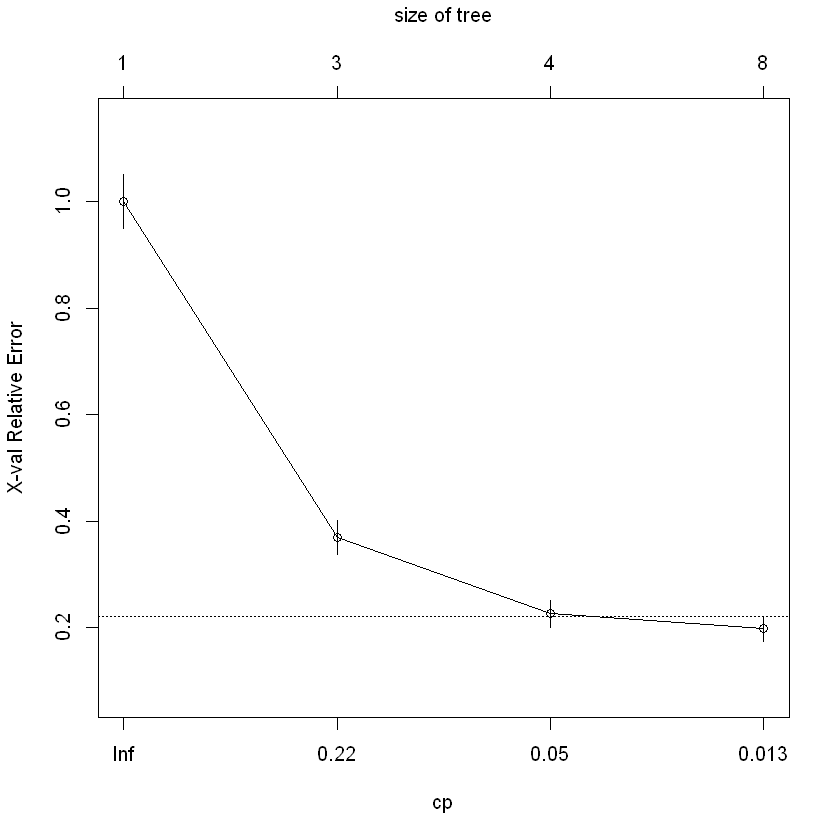

In [41]:
#CART model

set.seed(233)

cart.model.gini = rpart(bank.train$`Personal Loan`~., data = bank.train, method = "class",
                        parms = list(split="gini")) 

## checking the complexity parameter 
plotcp(cart.model.gini)   

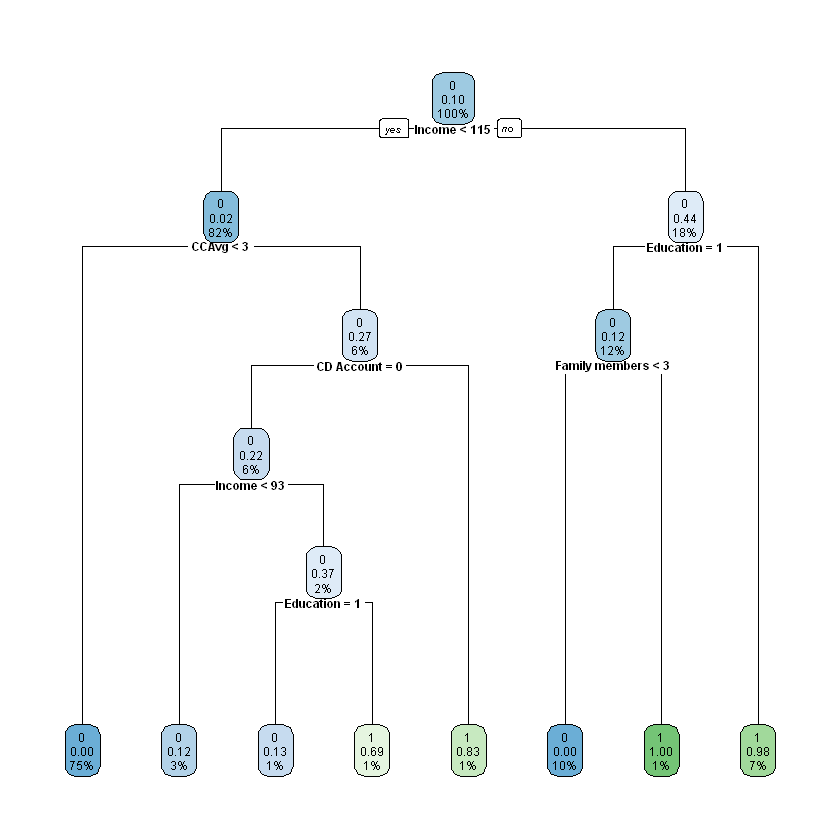

In [42]:
## plotting the classification tree 
rpart.plot(cart.model.gini, cex =0.6)

In [44]:
## checking the cptable to gauge the best crossvalidated error and correspoding
## Complexity paramter 
cart.model.gini$cptable

CP,nsplit,rel error,xerror,xstd
0.32521490,0,1.0000000,1.0000000,0.05078991
0.14326648,2,0.3495702,0.3696275,0.03193852
0.01719198,3,0.2063037,0.2263610,0.02517855
0.01000000,7,0.1346705,0.1977077,0.02356543


In [45]:
## checking for the variable importance for splitting of tree
cart.model.gini$variable.importance

Education         Income Family members          CCAvg     CD Account 
    232.137107     188.541598     142.501489     106.606257      56.904176 
      Mortgage     Experience            Age         Online 
     27.306276       3.445512       3.437672       1.751040

In [46]:
#Pruned CART Tree

## prunning the tree using the best complexity parameter
pruned.model = prune(cart.model.gini, cp = 0.015)

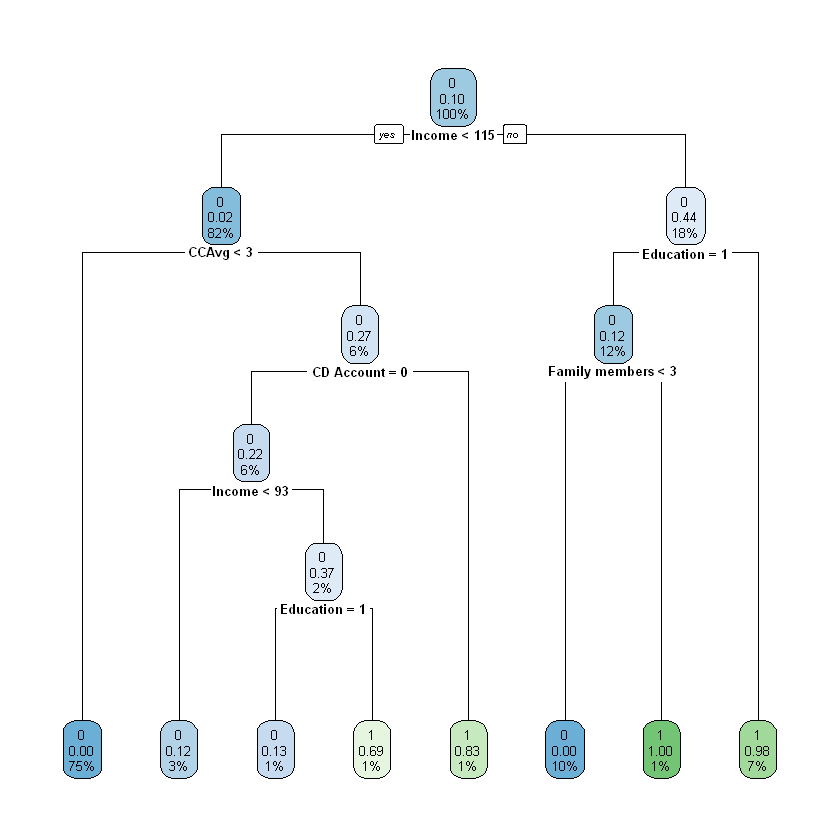

In [47]:
## plotting the prunned tree
rpart.plot(pruned.model, cex=0.65)

In [48]:
#CART prediction

cart.pred = predict(pruned.model, bank.test, type = "prob")

cart.pred.prob.1 = cart.pred[,1]
head(cart.pred.prob.1, 10)

## setting the threshold for probabilities to be considered as 1 
threshold = 0.70

bank.test$loanprediction = ifelse(cart.pred.prob.1 >= threshold, 1, 0)

bank.test$loanprediction = as.factor(bank.test$loanprediction)

Cart.Confusion.Matrix = confusionMatrix(bank.test$loanprediction, 
                                        reference = bank.test$`Personal Loan`, positive = "1")
Cart.Confusion.Matrix


1          2          3          4          5          6          7 
0.99734244 0.99734244 0.99734244 0.99734244 0.02109705 0.31428571 0.02109705 
         8          9         10 
0.99734244 0.02109705 0.99734244

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0    8  121
         1 1361   10
                                          
               Accuracy : 0.012           
                 95% CI : (0.0071, 0.0189)
    No Information Rate : 0.9127          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : -0.1738         
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.076336        
            Specificity : 0.005844        
         Pos Pred Value : 0.007294        
         Neg Pred Value : 0.062016        
             Prevalence : 0.087333        
         Detection Rate : 0.006667        
   Detection Prevalence : 0.914000        
      Balanced Accuracy : 0.041090        
                                          
       'Positive' Class : 1               
                        

In [49]:
#Random Forest

set.seed(1233)

RF = randomForest(formula = bank.test$`Personal Loan`~(bank.test$Age+bank.test$Experience+
                                                          bank.test$Income+bank.test$`Family members`+
                                                          bank.test$CCAvg+bank.test$Education+
                                                          bank.test$Mortgage+
                                                          bank.test$`Securities Account`+
                                                          bank.test$`CD Account`+
                                                          bank.test$Online+bank.test$CreditCard), 
                  data = bank.test)
print(RF)


Call:
 randomForest(formula = bank.test$`Personal Loan` ~ (bank.test$Age +      bank.test$Experience + bank.test$Income + bank.test$`Family members` +      bank.test$CCAvg + bank.test$Education + bank.test$Mortgage +      bank.test$`Securities Account` + bank.test$`CD Account` +      bank.test$Online + bank.test$CreditCard), data = bank.test) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3

        OOB estimate of  error rate: 1.67%
Confusion matrix:
     0   1 class.error
0 1364   5 0.003652301
1   20 111 0.152671756


In [50]:
## Print the error rate

err = RF$err.rate
head(err)

OOB,0,1
0.04444444,0.016293279,0.3265306
0.03526735,0.012422360,0.2837838
0.03388278,0.011964108,0.2808989
0.03228410,0.014084507,0.2330097
0.03611738,0.011522634,0.2982456
0.03089080,0.009426551,0.2605042


In [51]:
## out of bag error 
oob_err = err[nrow(err), "OOB"]
print(oob_err)  ## depicts the final out of bag error for all the samples

       OOB 
0.01666667 


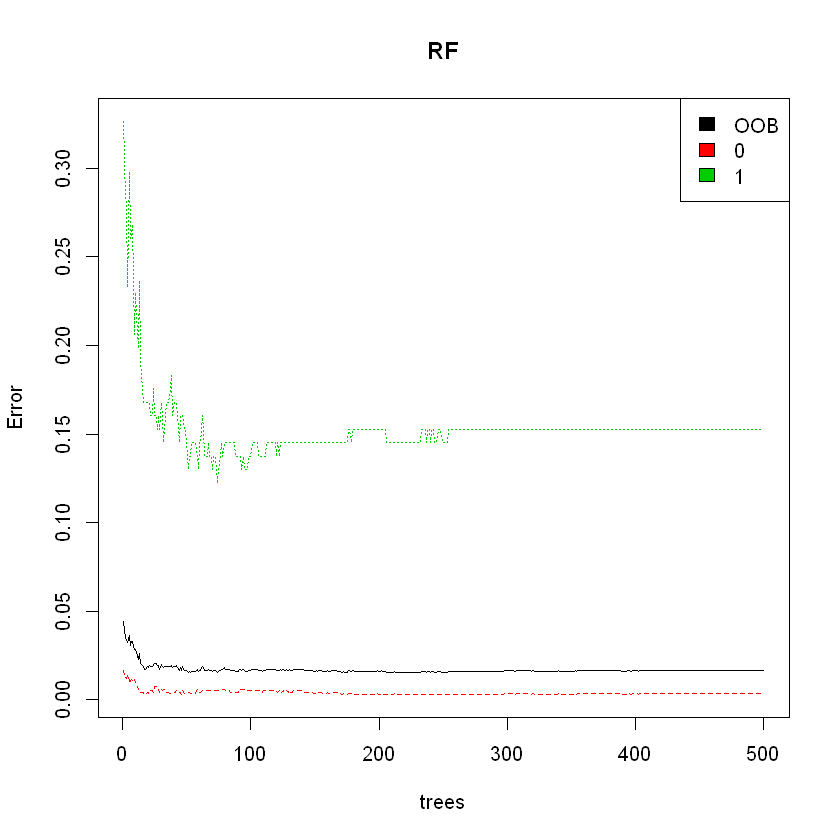

In [52]:
## plot the OOB error 

plot(RF)
legend(x="topright", legend = colnames(err), fill = 1:ncol(err))